# Facial Emotion Recognition with using CNN

Facial expressions are one of the ways humans communicate. Deep learning approaches in human and computer interactions are used in artificial intelligence research as an effective system application process. The detection of emotions or facial expressions in psychology necessitates the examination and evaluation of decisions in anticipating a person's feelings or a group of people communicating. This study proposes the development of a system that can predict and recognize the classification of facial emotions using the Convolution Neural Network (CNN) algorithm and feature extraction. 

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in the notebook. Facial expressions were predicted with the accuracy about <span style="color:crimson;">64</span> percent with using the Convolutional Neural Network (CNN). This algorithm was evaluated on a publicly available dataset from the <span style="color:crimson;">FER2013</span> database, which has 35887 48x48 grayscale face images each representing one of the emotions.

**Table of contents of this notebook:**

**1.** [Importing necessary libraries](#importing-necessary-libraries)

**2.** [Loading the data](#loading-the-data)

**3.** [Data pre-processing](#data-pre-processing)

**4.** [Design a model](#design-a-model)

**5.** [Fine tuning](#fine-tuning)

# 1. Importing necessary libraries <a id="importing-necessary-libraries"></a>

In [1]:
import tensorflow as tf # tensorflow 2.10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import time

# 2. Loading the data <a id="loading-the-data"></a>

In [2]:
data = pd.read_csv("fer2013.csv/fer2013.csv")
data.shape

(35887, 3)

To see the dataset has any missing values.

In [3]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


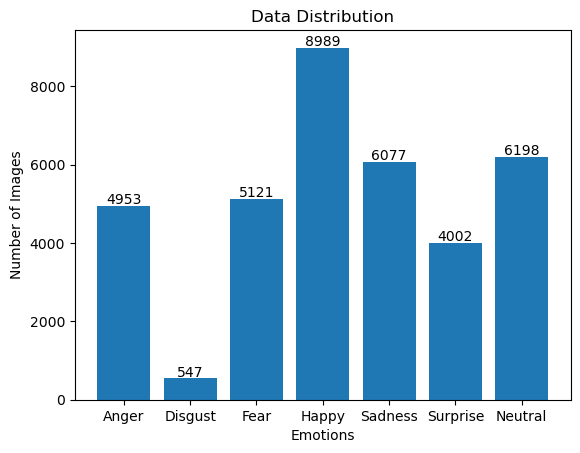

In [5]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', "Surprise",'Neutral']
emotion_counts = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])]
plt.bar(CLASS_LABELS, emotion_counts)
plt.title('Data Distribution')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
for i, count in enumerate(emotion_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)
plt.show()

# 3. Data pre-processing <a id="data-pre-processing"></a>

## 3.1 Shuffling the data, One Hot Encoding and Normalization

Firstly, we will shuffle the data using sample() function and determining fraction as 1 to shuffle the data by changing the rows.
Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.

In [6]:
data = data.sample(frac=1, random_state=123)
labels = tf.keras.utils.to_categorical(data['emotion'], num_classes=7)
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
pixels = train_pixels / 255.0
# Reshaping the data (48,48)
pixels = pixels.reshape((35887, 48, 48,1))

## 3.2 Train test validation split

Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=True, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, shuffle=True, random_state=123)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


We can see some train data containing one sample of each class with the help of this plot code.

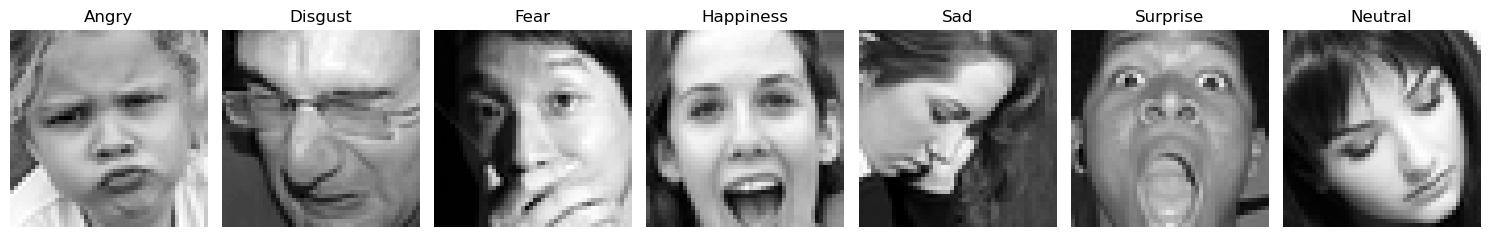

In [9]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
found_classes = [False] * 7
num_classes = 7
i = 0

for idx in range(len(y_train)):
    img = np.squeeze(X_train[idx])
    label_index = np.argmax(y_train[idx])

    if not found_classes[label_index]:
        found_classes[label_index] = True
        plt.subplot(1, num_classes, label_index + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_dict[label_index])
        plt.axis('off')
        
        if all(found_classes):
            break

plt.tight_layout()
plt.show()

## 3.6 Data augmentation using ImageDataGenerator

We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.

In [10]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

valgen = ImageDataGenerator() 

In [11]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

Our dataset is ready to feed our model. We will look at our model architecture.

# 4. Design a model <a id="design-a-model"></a>

## 4.1 CNN model

CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model. Then, we compile our model with Adam optimizer with 0.001 learning rate and chose metric as accuracy, then loss as categorical crossentropy

In [12]:
def cnn_model():
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(7, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
model = cnn_model()

In [14]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

## 4.2 Early stopping

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [16]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [17]:
#start_time = time.time()
history1 = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=2,
                    callbacks=[checkpointer],
                    validation_data=val_generator)
# end_time = time.time()
# training_time = end_time - start_time

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.28545, saving model to best_model.h5
909/909 - 13s - loss: 2.6956 - accuracy: 0.2083 - val_loss: 2.3103 - val_accuracy: 0.2854 - 13s/epoch - 14ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.28545 to 0.32291, saving model to best_model.h5
909/909 - 8s - loss: 2.4336 - accuracy: 0.2535 - val_loss: 2.2133 - val_accuracy: 0.3229 - 8s/epoch - 9ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.32291 to 0.33994, saving model to best_model.h5
909/909 - 8s - loss: 2.3024 - accuracy: 0.3021 - val_loss: 2.1727 - val_accuracy: 0.3399 - 8s/epoch - 9ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.33994 to 0.40433, saving model to best_model.h5
909/909 - 8s - loss: 2.1963 - accuracy: 0.3406 - val_loss: 2.0051 - val_accuracy: 0.4043 - 8s/epoch - 9ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.40433 to 0.40712, saving model to best_model.h5
909/909 - 8s - loss: 2.0784 - accuracy: 0.3731 - val_loss: 1.9661 

## 4.3 Visualizing results

In [18]:
# print("Training time: ", training_time/60)

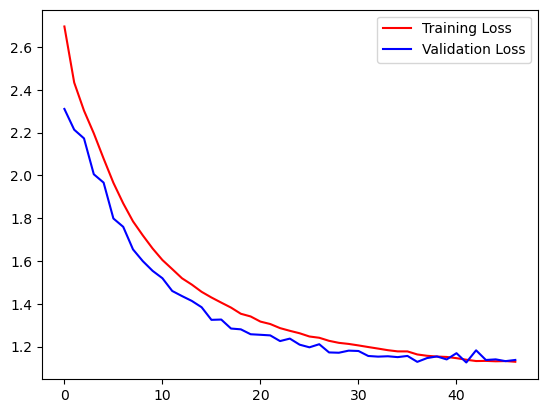

In [19]:
plt.plot(history1.history["loss"],'r', label="Training Loss")
plt.plot(history1.history["val_loss"],'b', label="Validation Loss")
plt.legend()
plt.savefig('training_validation_loss.png', dpi=300)
plt.show()

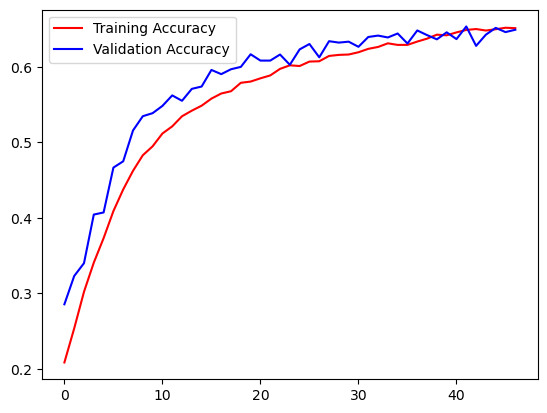

In [20]:
plt.plot(history1.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history1.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()
plt.savefig('training_validation_accuracy.png', dpi=300)
plt.show()

In [21]:
loss1 = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss1[1]))

113/113 [==============================] - 0s 3ms/step - loss: 1.1562 - accuracy: 0.6500
Test Acc: 0.6500418186187744


In [22]:
preds1 = model.predict(X_test)
y_pred1 = np.argmax(preds1 , axis = 1 )

113/113 [==============================] - 0s 2ms/step


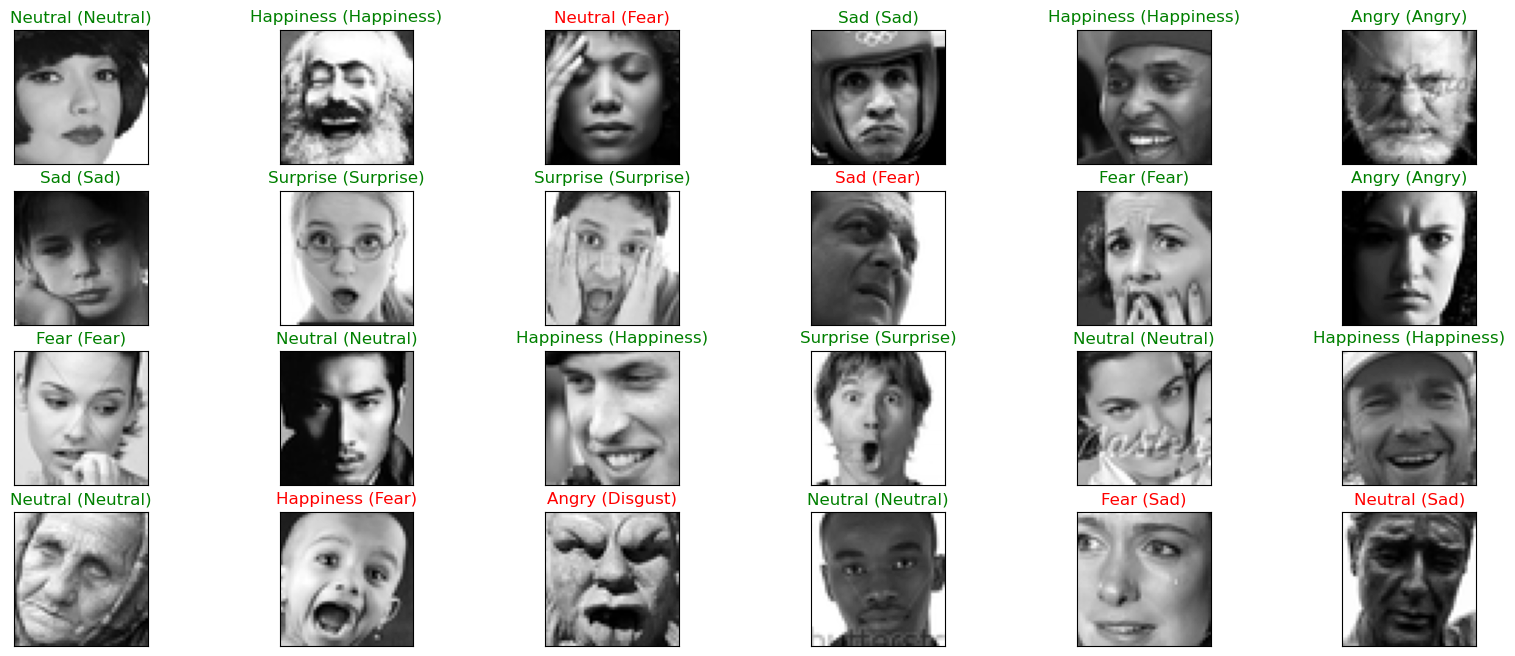

In [23]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]),cmap='gray')
    predict_index = label_dict[(y_pred1[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))
plt.savefig('predictions.png', dpi=300)
plt.show()

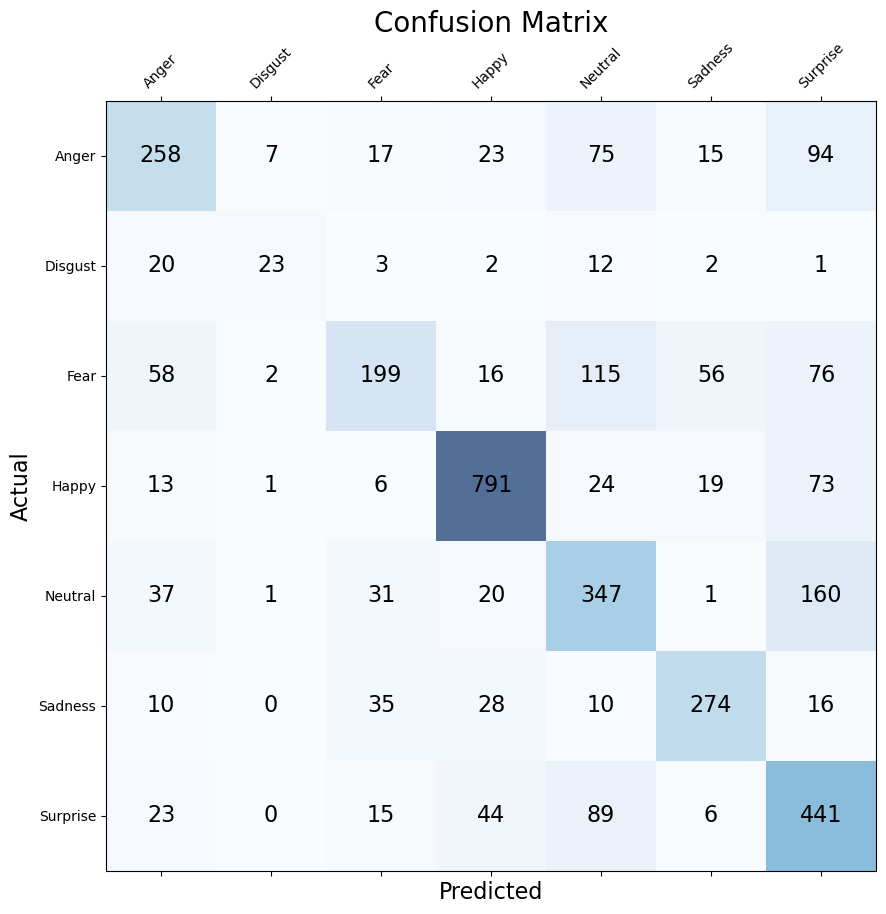

In [24]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = y_pred1

cm_data = tf.math.confusion_matrix(labels=y_test_labels, predictions=y_pred_labels).numpy()
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(15, 10))
ax.matshow(cm_data, cmap='Blues', alpha=0.7)  # 选择颜色为 "Blues"

for i in range(cm_data.shape[0]):
    for j in range(cm_data.shape[1]):
        ax.text(x=j, y=i, s=cm_data[i, j], va='center', ha='center', fontsize=16)  # 在每个格子中添加数字

plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(ticks=np.arange(len(CLASS_LABELS)), labels=CLASS_LABELS, rotation=45)  # 设置 x 轴标签
plt.yticks(ticks=np.arange(len(CLASS_LABELS)), labels=CLASS_LABELS)  # 设置 y 轴标签
plt.show()

In [25]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred1,digits=3))

              precision    recall  f1-score   support

           0      0.616     0.528     0.568       489
           1      0.676     0.365     0.474        63
           2      0.650     0.381     0.481       522
           3      0.856     0.853     0.855       927
           4      0.516     0.581     0.547       597
           5      0.735     0.735     0.735       373
           6      0.512     0.714     0.596       618

    accuracy                          0.650      3589
   macro avg      0.652     0.594     0.608      3589
weighted avg      0.662     0.650     0.646      3589



# 5. Fine tuning <a id="fine-tuning"></a>

## 5.1 Changing optimizer

Changing Optimizer to Stochastic Gradient Descent (SGD)

In [26]:
model = cnn_model()

In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.0001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [28]:
history2 = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=2,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30

Epoch 1: val_accuracy did not improve from 0.65356
909/909 - 9s - loss: 3.1811 - accuracy: 0.1543 - val_loss: 2.6621 - val_accuracy: 0.1737 - 9s/epoch - 10ms/step
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.65356
909/909 - 8s - loss: 3.0753 - accuracy: 0.1674 - val_loss: 2.5981 - val_accuracy: 0.1854 - 8s/epoch - 9ms/step
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.65356
909/909 - 8s - loss: 3.0116 - accuracy: 0.1714 - val_loss: 2.5626 - val_accuracy: 0.2022 - 8s/epoch - 9ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.65356
909/909 - 8s - loss: 2.9444 - accuracy: 0.1828 - val_loss: 2.5232 - val_accuracy: 0.2084 - 8s/epoch - 9ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.65356
909/909 - 8s - loss: 2.8705 - accuracy: 0.1899 - val_loss: 2.5015 - val_accuracy: 0.2040 - 8s/epoch - 9ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.65356
909/909 - 8s - loss: 2.8500 - accuracy: 0.1912 - val_loss: 2.4716 

In [29]:
loss2 = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss2[1]))

113/113 [==============================] - 0s 3ms/step - loss: 2.2551 - accuracy: 0.3318
Test Acc: 0.33184731006622314


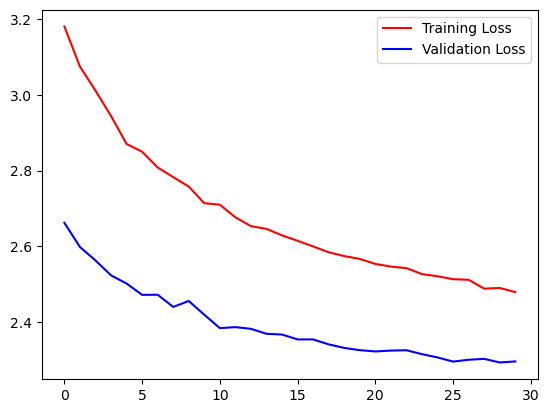

In [30]:
plt.plot(history2.history["loss"],'r', label="Training Loss")
plt.plot(history2.history["val_loss"],'b', label="Validation Loss")
plt.legend()

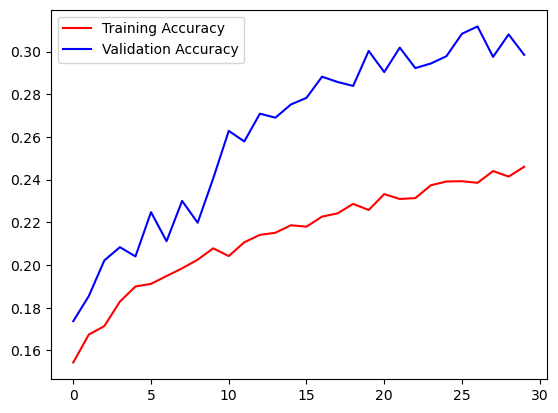

In [31]:
plt.plot(history2.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history2.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

The model trained with SGD did not give better results than Adam optimizer.

## 5.2 Changing epoch number

Let's reduce the learning rate, change the epoch number as 80 and increase the patience of early stop for the cnn_model.

In [32]:
model = cnn_model()

In [33]:
model.compile(
    optimizer = Adam(learning_rate=0.00005), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [34]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [35]:
history3 = model.fit(train_generator,
                    epochs=80,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/80
907/909 [============================>.] - ETA: 0s - loss: 2.8583 - accuracy: 0.1902
Epoch 1: val_accuracy improved from -inf to 0.23839, saving model to best_model.h5
909/909 [==============================] - 9s 10ms/step - loss: 2.8585 - accuracy: 0.1902 - val_loss: 2.5633 - val_accuracy: 0.2384
Epoch 2/80
904/909 [============================>.] - ETA: 0s - loss: 2.5776 - accuracy: 0.2218
Epoch 2: val_accuracy improved from 0.23839 to 0.27895, saving model to best_model.h5
909/909 [==============================] - 9s 9ms/step - loss: 2.5772 - accuracy: 0.2217 - val_loss: 2.4135 - val_accuracy: 0.2789
Epoch 3/80
903/909 [============================>.] - ETA: 0s - loss: 2.4715 - accuracy: 0.2459
Epoch 3: val_accuracy improved from 0.27895 to 0.29814, saving model to best_model.h5
909/909 [==============================] - 9s 9ms/step - loss: 2.4712 - accuracy: 0.2460 - val_loss: 2.2877 - val_accuracy: 0.2981
Epoch 4/80
908/909 [============================>.] - ETA: 0s -

In [37]:
loss3 = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss3[1]))

113/113 [==============================] - 1s 5ms/step - loss: 1.1002 - accuracy: 0.6656
Test Acc: 0.6656450033187866


In [39]:
preds3 = model.predict(X_test)
y_pred3 = np.argmax(preds3 , axis = 1 )

113/113 [==============================] - 0s 3ms/step


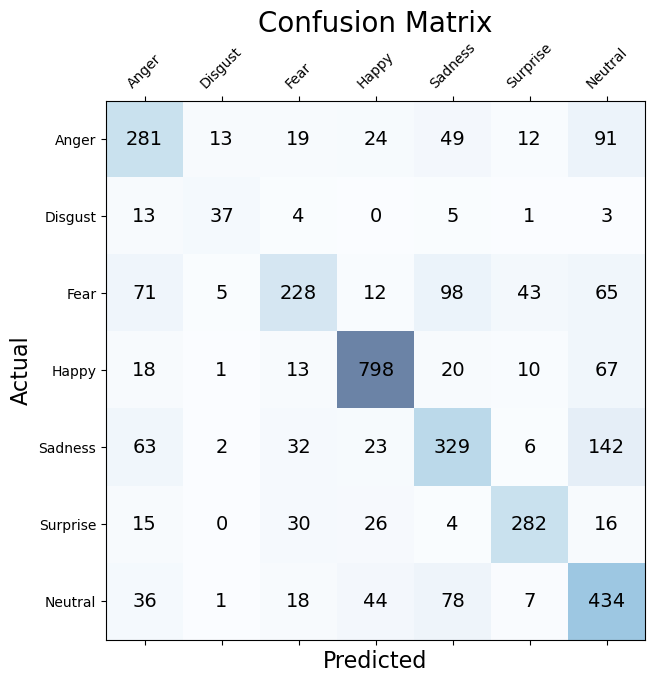

In [40]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', "Surprise",'Neutral']

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = y_pred3

cm_data = tf.math.confusion_matrix(labels=y_test_labels, predictions=y_pred_labels).numpy()
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(10, 7))
ax.matshow(cm_data, cmap='Blues', alpha=0.6)

for i in range(cm_data.shape[0]):
    for j in range(cm_data.shape[1]):
        ax.text(x=j, y=i, s=cm_data[i, j], va='center', ha='center', fontsize=14)

plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(ticks=np.arange(len(CLASS_LABELS)), labels=CLASS_LABELS, rotation=45)
plt.yticks(ticks=np.arange(len(CLASS_LABELS)), labels=CLASS_LABELS)
plt.show()

In [41]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred3,digits=3))

              precision    recall  f1-score   support

           0      0.565     0.575     0.570       489
           1      0.627     0.587     0.607        63
           2      0.663     0.437     0.527       522
           3      0.861     0.861     0.861       927
           4      0.564     0.551     0.558       597
           5      0.781     0.756     0.768       373
           6      0.531     0.702     0.604       618

    accuracy                          0.666      3589
   macro avg      0.656     0.638     0.642      3589
weighted avg      0.673     0.666     0.664      3589

